In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import scatter
from operator import itemgetter
from sklearn.decomposition import PCA

In [65]:
train1_df = pd.read_csv('BATADAL_dataset03.csv', index_col=0)
train2_df = pd.read_csv('BATADAL_dataset04.csv', index_col=0)
test_df = pd.read_csv('BATADAL_test_dataset.csv', index_col=0)

In [66]:
# train2_df = train2_df['values'].apply(lambda x: x.str.strip() if x.dtype == "object" else x)
train2_df = train2_df.rename(columns=lambda x: x.strip())
train2_df.index = pd.to_datetime(train2_df.index, dayfirst=True)

counter = 0
found_c = 0
bit = 0
counter_list = []
for rindex, row in train2_df.iterrows():
    if row['ATT_FLAG'] == 1:
        if bit == 0:
            counter = 0
            bit = 1
            found_c+=1
        counter+=1
    else:
        if bit == 1:
            for c in range(counter):
                counter_list.append((c+1)/counter)
            bit = 0 
        counter_list.append(0)
        
train2_df['TDD'] = counter_list

# print(train2_df.head())
# print(train2_df[train2_df['ATT_FLAG'] == 1])
        

X_train1 = train1_df.drop(['ATT_FLAG'], axis=1).values
y_train1 = train1_df['ATT_FLAG'].values
X_train2 = train2_df.drop(['ATT_FLAG', 'TDD'], axis=1).values
y_train2 = train2_df['ATT_FLAG'].values
# anom_df = train2_df[train2_df['ATT_FLAG']==1]
# X_train_anom = anom_df.drop(['ATT_FLAG'], axis=1).values
print(np.shape(X_train1))
print(np.shape(X_train2))
# print(np.shape(X_train_anom))


(8761, 43)
(4177, 43)


In [67]:
def plot_dataset(X, y):
    _X = np.sum(X, axis=1)
    df = pd.DataFrame(dict(y=_X, x=range(len(y)), label=y))
    colors = {1: 'red', -999: 'blue'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='line', x='x', y='y', label=key, color=colors[key])
    plt.axis('equal')
    plt.show()

In [68]:
#Standarizing the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train1)
X_std2 = scaler.transform(X_train2)
# X_std3 = scaler.transform(X_train_anom)

print(np.shape(X_std))

# eigendecomposition on the covariance matrix:
cov_mat = np.cov(X_std.T)
cov_mat2 = np.cov(X_std2.T)
print(np.shape(cov_mat))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(np.shape(eig_vecs))

eig_vals2, eig_vecs2 = np.linalg.eig(cov_mat2)

(8761, 43)
(43, 43)
(43, 43)


In [69]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


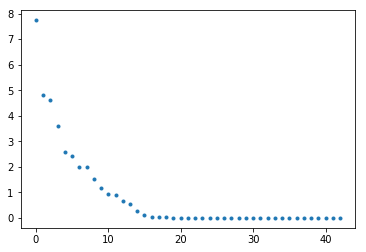

In [70]:
eig_vals_sort = np.sort(eig_vals)[::-1]
# print(eig_vals_sort)

plt.plot(eig_vals_sort, '.')
plt.show()

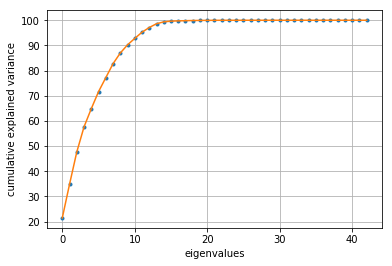

In [71]:
# eig_val_sort_ind = np.argsort(eig_vals)[::-1]

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.plot(cum_var_exp, '.')
plt.plot(cum_var_exp, '-')
plt.xlabel('eigenvalues')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

In [116]:
pca = PCA(n_components=15)
pca.fit(X_std)
scores = pca.transform(X_std)
reconstruct = pca.inverse_transform(scores )
residual_pca1=X_std-reconstruct
residual_pca1 = np.sqrt(np.square(residual_pca1))
print(np.shape(residual_pca1))
residual_full = np.sum(residual_pca1, axis=1)
print(np.shape(residual_full))


(8761, 43)
(8761,)


(8761,)
(4177, 43)
(8761,)


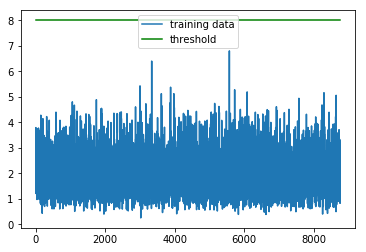

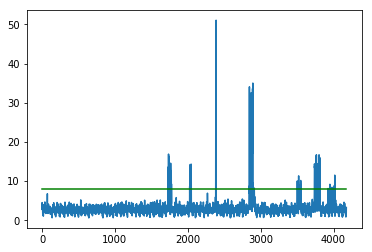

In [117]:
residual_full = np.sum(residual_pca1, axis=1)
print(np.shape(residual_full))
scores2 = pca.transform(X_std2)
# Reconstruct from the 2 dimensional scores 
reconstruct2 = pca.inverse_transform(scores2)

residual_pca2=X_std2-reconstruct2
residual_pca2 = np.sqrt(np.square(residual_pca2))
print(np.shape(residual_pca2))
residual_full2 = np.sum(residual_pca2, axis=1)
print(np.shape(residual_full))

threshold = 8

plt.plot(residual_full, label='training data')
plt.plot([0,len(residual_full)],[threshold, threshold],'g', label='threshold')
# plt.title('Full residual')
plt.legend()
plt.show()

plt.plot(residual_full2, label='val')
plt.plot([0,len(residual_full2)],[threshold, threshold],'g')
# plt.title('Full residual')
plt.show()

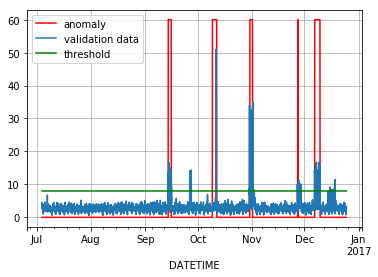

In [122]:
# plot_dataset(X_train2, y_train2)
train2_df['threshold'] = np.ones(len(train2_df))*threshold
train2_df['ATT_FLAG_anom'] = np.where(train2_df['ATT_FLAG'] == 1, 60, 0)
ax = train2_df['ATT_FLAG_anom'].plot(grid=True, color='r', label='anomaly')
train2_df['pca_anom'] = residual_full2
ax2 = train2_df['pca_anom'].plot(grid=True, label='validation data')
ax3 = train2_df['threshold'].plot(grid=True, color='g', label='threshold')
plt.legend(loc=2)
plt.show()

In [119]:
def TDD_metric(train2_df, y_pred):
    counter = 0
    found_c = 0
    bit = 0
    counter_list = []
    for rindex, row in train2_df.iterrows():
        if row['ATT_FLAG'] == 1:
            if bit == 0:
                counter = 0
                bit = 1
                found_c+=1
            counter+=1
        else:
            if bit == 1:
                for c in range(counter):
                    counter_list.append((c+1)/counter)
                bit = 0 
            counter_list.append(0)

    train2_df['TDD'] = counter_list
    train2_df['y_pred'] = y_pred
    
    counter = 0
    found_c = 0
    
    arr = train2_df[['ATT_FLAG', 'TDD']].values
    for i in range(len(arr)):#rindex, row in train2_df.iterrows():
        if arr[i][0] == 1:
            if y_pred[i] == 1 and bit == 0:
#                 print(arr[i][1])
                counter += arr[i][1]
                bit = 1
                found_c+=1
        else:
            bit = 0 
#     print('A')
#     print(counter, found_c)
    S_TDD = 1 - counter/found_c
    return S_TDD


In [120]:
def S_cm(TP, FP, TN, FN):
    TPR = TP/(TP + FN)
    TNR = TN/(FP + TN)
    return (TPR + TNR)/2

In [121]:
#indices where positive occurs
ind = np.argwhere(residual_full2 > threshold).reshape(-1)
y_pred = np.where(residual_full2 > threshold, 1, 0)
# print(np.count_nonzero(y_pred == 1))
P_am = np.where(y_train2 == 1) # indices with positive
N_am = np.where(y_train2 == -999) # indices with negative

print(N_am)
print(len(ind))

mask_TP = np.isin(ind, P_am)
mask_NP = np.isin(ind, N_am)

TP = len(ind[mask_TP])
FP = len(ind[mask_NP])
TN = np.shape(N_am)[1] - FP
FN = np.shape(P_am)[1] - TP

print(TP, FP, TN, FN)
print(TP + FP + TN + FN, np.shape(P_am)[1] + np.shape(N_am)[1], len(residual_full2))

accuracy = (TP+TN)/len(y_train2)
precision = TP/(TP+FP)
recall = TP/(np.shape(P_am)[1])
S_TTD = TDD_metric(train2_df, y_pred)
S_CM = S_cm(TP, FP, TN, FN)
print('accuracy: {}, precision: {}, recall: {}'.format(accuracy, precision, recall))
print('batadal: {}'.format(S_TTD))
print('S_cm: {}'.format(S_CM))
print('Ranked: {}'.format(0.5 * S_TTD + 0.5 * S_CM))

(array([   0,    1,    2, ..., 4174, 4175, 4176], dtype=int32),)
149
87 62 3896 132
4177 4177 4177
accuracy: 0.9535551831457985, precision: 0.5838926174496645, recall: 0.3972602739726027
batadal: 0.7838662047566156
S_cm: 0.6907978984820062
Ranked: 0.7373320516193109
